In [1]:
import pandas as pd
import geopandas as gpd
import shapely
from shapely.wkt import loads
import matplotlib.pyplot as plt


## restaurant

In [2]:
df = gpd.read_file(r"D:\bike\data\深圳市POI\ShapeFile\深圳市_餐饮服务_20220602_034130.shp")

In [3]:
df.head()

,parent,distance,pcode,importance,biz_ext,recommend,type,photos,discount_n,gridcode,...,groupbuy_n,longitude_,latitude_g,longitud_1,latitude_w,typecode_s,大类,中类,小类,geometry
0,[],[],440000,[],"{'cost': [], 'rating': [], 'meal_ordering': '0'}",0,餐饮服务;餐饮相关场所;餐饮相关,[],0,3413061122,...,0,113.772106,22.681099,113.766957,22.683956,50000,餐饮服务,餐饮相关场所,餐饮相关,POINT (113.76696 22.68396)
1,[],[],440000,[],"{'cost': [], 'rating': '4.2', 'meal_ordering':...",0,餐饮服务;中餐厅;中餐厅,"[{'title': [], 'url': 'http://store.is.autonav...",0,3413062210,...,0,113.776722,22.686121,113.771580,22.688980,50100,餐饮服务,中餐厅,中餐厅,POINT (113.77158 22.68898)
2,[],[],440000,[],"{'cost': [], 'rating': '3.8', 'meal_ordering':...",0,餐饮服务;中餐厅;中餐厅,[],0,3413062200,...,0,113.776765,22.685959,113.771623,22.688819,50100,餐饮服务,中餐厅,中餐厅,POINT (113.77162 22.68882)
3,[],[],440000,[],"{'cost': [], 'rating': [], 'meal_ordering': '0'}",0,餐饮服务;中餐厅;中餐厅,[],0,3413062200,...,0,113.776758,22.686088,113.771616,22.688948,50100,餐饮服务,中餐厅,中餐厅,POINT (113.77162 22.68895)
4,[],[],440000,[],"{'cost': [], 'rating': '4.1', 'meal_ordering':...",0,餐饮服务;快餐厅;快餐厅,"[{'title': [], 'url': 'https://img.alicdn.com/...",0,3413061201,...,0,113.781828,22.676027,113.776696,22.678894,50300,餐饮服务,快餐厅,快餐厅,POINT (113.77670 22.67889)


In [4]:
len(df)

138227

In [5]:
df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

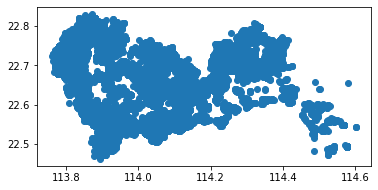

In [6]:
df.plot()

In [7]:
from sklearn.cluster import DBSCAN
import numpy as np
from shapely.geometry import MultiPoint

In [8]:
def dbscan_cluster(gdf_tmp, epsilon, min_samples, plot=False): 

    # convert epsilon from km to radians
    kms_per_radian = 6371.0088

    gdf_tmp = gdf_tmp.to_crs(4326)
    gdf_tmp['lat'] = gdf_tmp.geometry.y
    gdf_tmp['lon'] = gdf_tmp.geometry.x
    coords = gdf_tmp[['lat','lon']].to_numpy()

    # set up the algorithm
    dbscan = DBSCAN(
        eps = epsilon/kms_per_radian,
        min_samples = min_samples,
        algorithm = 'ball_tree',
        metric = 'haversine')

    # fit the algorithm
    db = dbscan.fit(np.radians(coords))

    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
    print('Number of clusters: {}'.format(num_clusters))

    if plot:
        gdf_tmp['cluster'] = cluster_labels
        fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(20,10))
        gdf_tmp.loc[gdf_tmp.cluster!=-1].plot(ax=ax1,column='cluster')
        gdf_tmp.loc[gdf_tmp.cluster==-1].plot(ax=ax1,color='black',alpha=0.01)
        gdf_tmp[['cluster']].plot.hist(ax=ax2)

    return cluster_labels, clusters

In [9]:
# continue here

Number of clusters: 12


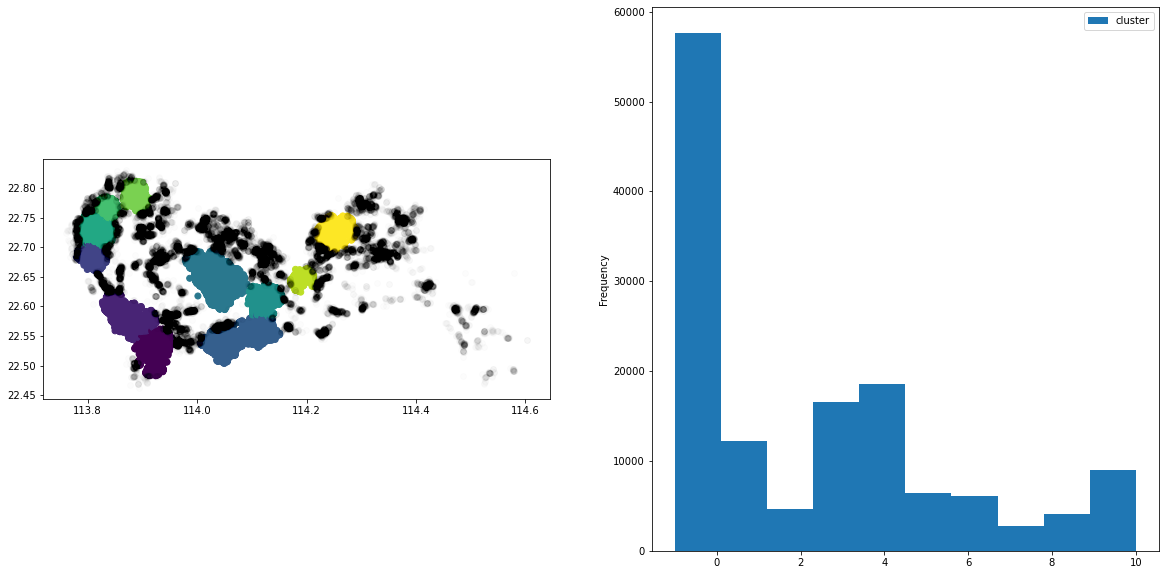

In [10]:
#inputs:
epsilon = 2 #km
min_samples = int(len(df)*0.02) # 1% of the sample should go into the 2km circle

df['cluster'], cluster = dbscan_cluster(df,epsilon,min_samples,plot=True)

In [11]:
from geopy.distance import great_circle

In [12]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

cluster = cluster[cluster.str.len() !=0]
centermost_points = cluster.map(get_centermost_point)


In [13]:
centermost_points

0     (22.524013550445662, 113.92373997855366)
1         (22.58130977335, 113.87259522634156)
2     (22.683000805272208, 113.80700152478975)
3      (22.54447839697328, 114.07940707400532)
4      (22.64619750751491, 114.03359019314745)
5       (22.61060181364274, 114.1224951871775)
6      (22.73098878478112, 113.81494925611663)
7       (22.7672158114809, 113.83743407322426)
8      (22.78587740667439, 113.88729658114546)
9      (22.64733655091955, 114.19382399819696)
10    (22.726048486920305, 114.25405054729804)
dtype: object

In [14]:
CRS_UNI = 4326
def convert_to_points(centermost_points, local_crs):
    df_tmp = pd.DataFrame([[*a] for a in centermost_points],columns=('x','y'))
    geometry = gpd.points_from_xy(df_tmp.y,df_tmp.x)
    gdf_local_cbd = gpd.GeoDataFrame(geometry = geometry, crs = CRS_UNI)
    gdf_local_cbd = gdf_local_cbd.to_crs(local_crs)
    return gdf_local_cbd

In [15]:
local_crs = 4326
gdf_local_cbd = convert_to_points(centermost_points, local_crs)

<AxesSubplot:>

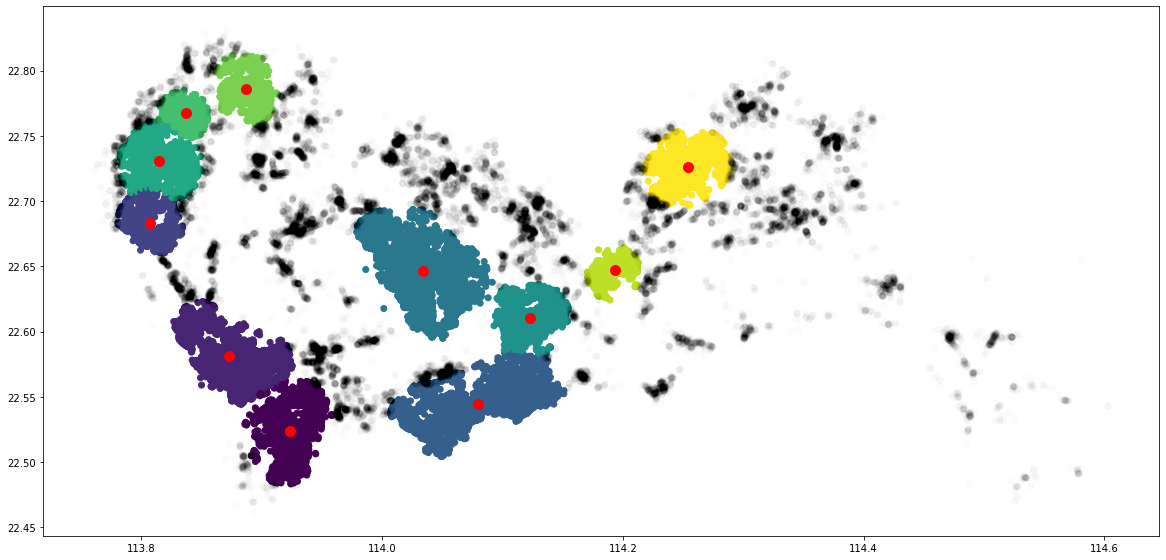

In [16]:
fig,ax1 = plt.subplots(figsize=(20,10))
df.loc[df.cluster!=-1].plot(ax=ax1,column='cluster')
df.loc[df.cluster==-1].plot(ax=ax1,color='black',alpha=0.01)
gdf_local_cbd.plot(ax=ax1, color='red', markersize=100)

In [17]:
# berlin subcenters look ok - let's try it for all

In [18]:
gdf_local_cbd

,geometry
0,POINT (113.92374 22.52401)
1,POINT (113.87260 22.58131)
2,POINT (113.80700 22.68300)
3,POINT (114.07941 22.54448)
4,POINT (114.03359 22.64620)
5,POINT (114.12250 22.61060)
6,POINT (113.81495 22.73099)
7,POINT (113.83743 22.76722)
8,POINT (113.88730 22.78588)
9,POINT (114.19382 22.64734)


In [19]:
gdf_local_cbd.to_csv(r"D:\bike\code\metro\Preprocessing-bike data\code\day_buffer\variable\distance\gdf_local_cbd_food.csv")

## shoppinig

In [20]:
df = gpd.read_file(r"D:\bike\data\深圳市POI\ShapeFile\深圳市_购物服务_20220602_035618.shp")

In [21]:
df.head()

,parent,distance,pcode,importance,biz_ext,recommend,type,photos,discount_n,gridcode,...,groupbuy_n,longitude_,latitude_g,longitud_1,latitude_w,typecode_s,大类,中类,小类,geometry
0,[],[],440000,[],"{'cost': [], 'rating': '3.5'}",0,购物服务;家居建材市场;建材五金市场,[],0,3413060102,...,0,113.771722,22.667040,113.766573,22.669900,60603,购物服务,家居建材市场,建材五金市场,POINT (113.76657 22.66990)
1,[],[],440000,[],"{'cost': [], 'rating': '3.2'}",0,购物服务;家居建材市场;建材五金市场,[],0,3413060102,...,0,113.771703,22.666889,113.766554,22.669749,60603,购物服务,家居建材市场,建材五金市场,POINT (113.76655 22.66975)
2,[],[],440000,[],"{'cost': [], 'rating': []}",0,购物服务;家居建材市场;建材五金市场,[],0,3413060102,...,0,113.772154,22.666699,113.767006,22.669559,60603,购物服务,家居建材市场,建材五金市场,POINT (113.76701 22.66956)
3,[],[],440000,[],"{'cost': [], 'rating': '4.8'}",0,购物服务;家居建材市场;建材五金市场,"[{'title': [], 'url': 'http://store.is.autonav...",0,3413061121,...,0,113.769788,22.681757,113.764636,22.684612,60603,购物服务,家居建材市场,建材五金市场,POINT (113.76464 22.68461)
4,[],[],440000,[],"{'cost': [], 'rating': '3.6'}",0,购物服务;便民商店/便利店;便民商店/便利店,[],0,3413062200,...,0,113.776848,22.685651,113.771706,22.688511,60200,购物服务,便民商店/便利店,便民商店/便利店,POINT (113.77171 22.68851)


In [22]:
len(df)

206938

In [23]:
df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

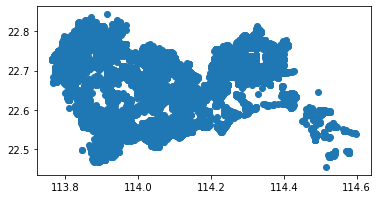

In [24]:
df.plot()

In [25]:
from sklearn.cluster import DBSCAN
import numpy as np
from shapely.geometry import MultiPoint

In [26]:
def dbscan_cluster(gdf_tmp, epsilon, min_samples, plot=False): 

    # convert epsilon from km to radians
    kms_per_radian = 6371.0088

    gdf_tmp = gdf_tmp.to_crs(4326)
    gdf_tmp['lat'] = gdf_tmp.geometry.y
    gdf_tmp['lon'] = gdf_tmp.geometry.x
    coords = gdf_tmp[['lat','lon']].to_numpy()

    # set up the algorithm
    dbscan = DBSCAN(
        eps = epsilon/kms_per_radian,
        min_samples = min_samples,
        algorithm = 'ball_tree',
        metric = 'haversine')

    # fit the algorithm
    db = dbscan.fit(np.radians(coords))

    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
    print('Number of clusters: {}'.format(num_clusters))

    if plot:
        gdf_tmp['cluster'] = cluster_labels
        fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(20,10))
        gdf_tmp.loc[gdf_tmp.cluster!=-1].plot(ax=ax1,column='cluster')
        gdf_tmp.loc[gdf_tmp.cluster==-1].plot(ax=ax1,color='black',alpha=0.01)
        gdf_tmp[['cluster']].plot.hist(ax=ax2)

    return cluster_labels, clusters

Number of clusters: 11


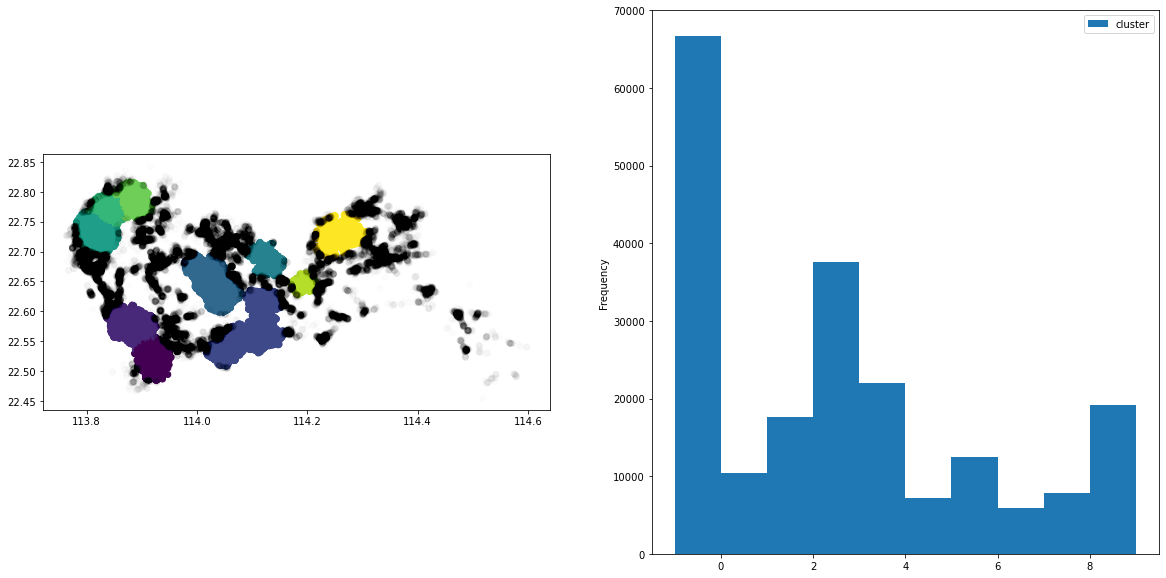

In [27]:
#inputs:
epsilon = 2 #km
min_samples = int(len(df)*0.02) # 1% of the sample should go into the 2km circle

df['cluster'], cluster = dbscan_cluster(df,epsilon,min_samples,plot=True)

In [28]:
from geopy.distance import great_circle

In [29]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

cluster = cluster[cluster.str.len() !=0]
centermost_points = cluster.map(get_centermost_point)


In [30]:
centermost_points

0    (22.519765057045056, 113.92169531589283)
1    (22.576623434446034, 113.87850615173863)
2    (22.564958174121333, 114.09790716161046)
3     (22.64713983555942, 114.02783454636489)
4      (22.68577726264015, 114.1235513611711)
5    (22.730897980571054, 113.81717820872856)
6    (22.770003239296088, 113.83984316887688)
7    (22.784176167877884, 113.88776522167603)
8     (22.64721251713655, 114.19503389563958)
9    (22.726737707319344, 114.25561983019767)
dtype: object

In [31]:
CRS_UNI = 4326
def convert_to_points(centermost_points, local_crs):
    df_tmp = pd.DataFrame([[*a] for a in centermost_points],columns=('x','y'))
    geometry = gpd.points_from_xy(df_tmp.y,df_tmp.x)
    gdf_local_cbd = gpd.GeoDataFrame(geometry = geometry, crs = CRS_UNI)
    gdf_local_cbd = gdf_local_cbd.to_crs(local_crs)
    return gdf_local_cbd

In [32]:
local_crs = 4326
gdf_local_cbd = convert_to_points(centermost_points, local_crs)

<AxesSubplot:>

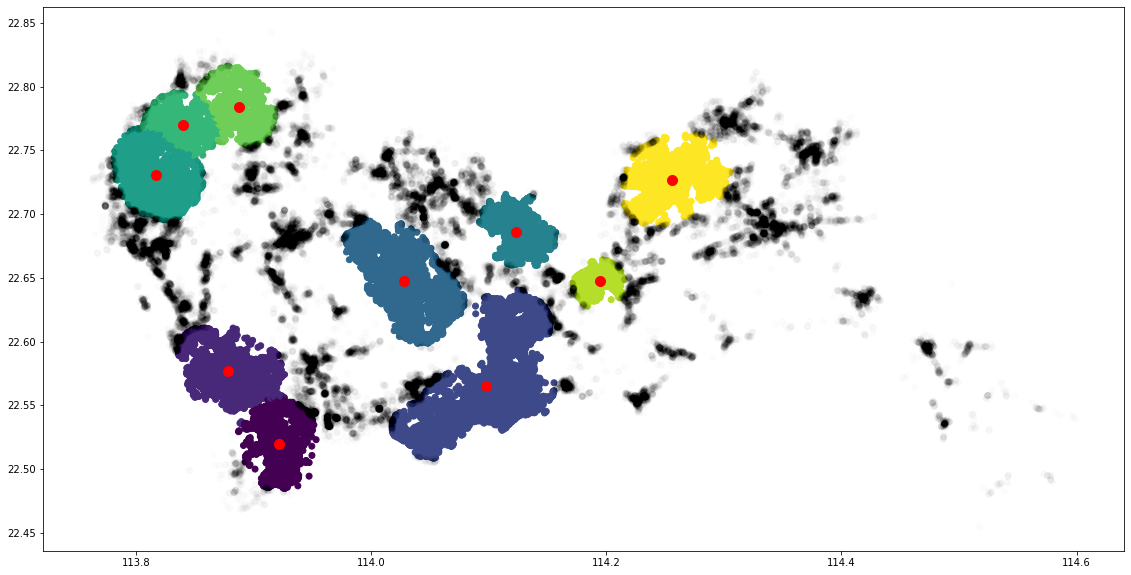

In [33]:
fig,ax1 = plt.subplots(figsize=(20,10))
df.loc[df.cluster!=-1].plot(ax=ax1,column='cluster')
df.loc[df.cluster==-1].plot(ax=ax1,color='black',alpha=0.01)
gdf_local_cbd.plot(ax=ax1, color='red', markersize=100)

In [34]:
# berlin subcenters look ok - let's try it for all

In [35]:
gdf_local_cbd

,geometry
0,POINT (113.92170 22.51977)
1,POINT (113.87851 22.57662)
2,POINT (114.09791 22.56496)
3,POINT (114.02783 22.64714)
4,POINT (114.12355 22.68578)
5,POINT (113.81718 22.73090)
6,POINT (113.83984 22.77000)
7,POINT (113.88777 22.78418)
8,POINT (114.19503 22.64721)
9,POINT (114.25562 22.72674)


In [36]:
gdf_local_cbd.to_csv(r"D:\bike\code\metro\Preprocessing-bike data\code\day_buffer\variable\distance\gdf_local_cbd_shpping.csv")

## commercial building

In [37]:
df = gpd.read_file(r"D:\bike\data\深圳市POI\ShapeFile\深圳市_商务住宅_20220602_040833.shp")

In [38]:
df.head()

,parent,distance,pcode,importance,biz_ext,recommend,type,photos,discount_n,gridcode,...,groupbuy_n,longitude_,latitude_g,longitud_1,latitude_w,typecode_s,大类,中类,小类,geometry
0,[],[],440000,[],"{'cost': [], 'rating': []}",0,商务住宅;产业园区;产业园区,[],0,3413060221,...,0,113.782171,22.672881,113.777039,22.675749,120100,商务住宅,产业园区,产业园区,POINT (113.77704 22.67575)
1,[],[],440000,[],"{'cost': [], 'rating': []}",0,商务住宅;产业园区;产业园区,"[{'title': [], 'url': 'http://store.is.autonav...",0,3413061201,...,0,113.783157,22.676067,113.778027,22.678936,120100,商务住宅,产业园区,产业园区,POINT (113.77803 22.67894)
2,[],[],440000,[],"{'cost': [], 'rating': []}",0,商务住宅;楼宇;商务写字楼,[],0,3413061202,...,0,113.783175,22.676811,113.778045,22.679680,120201,商务住宅,楼宇,商务写字楼,POINT (113.77805 22.67968)
3,[],[],440000,[],"{'cost': [], 'rating': []}",0,商务住宅;产业园区;产业园区,"[{'title': [], 'url': 'http://store.is.autonav...",0,3413061202,...,0,113.784663,22.676330,113.779536,22.679200,120100,商务住宅,产业园区,产业园区,POINT (113.77954 22.67920)
4,[],[],440000,[],"{'cost': '15677.00', 'rating': []}",0,商务住宅;住宅区;住宅小区,"[{'title': '外景图', 'url': 'http://store.is.auto...",0,3413061202,...,0,113.782742,22.676202,113.777611,22.679070,120302,商务住宅,住宅区,住宅小区,POINT (113.77761 22.67907)


In [39]:
len(df)

28771

In [40]:
df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

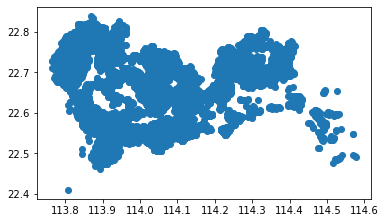

In [41]:
df.plot()

In [42]:
from sklearn.cluster import DBSCAN
import numpy as np
from shapely.geometry import MultiPoint

In [43]:
def dbscan_cluster(gdf_tmp, epsilon, min_samples, plot=False): 

    # convert epsilon from km to radians
    kms_per_radian = 6371.0088

    gdf_tmp = gdf_tmp.to_crs(4326)
    gdf_tmp['lat'] = gdf_tmp.geometry.y
    gdf_tmp['lon'] = gdf_tmp.geometry.x
    coords = gdf_tmp[['lat','lon']].to_numpy()

    # set up the algorithm
    dbscan = DBSCAN(
        eps = epsilon/kms_per_radian,
        min_samples = min_samples,
        algorithm = 'ball_tree',
        metric = 'haversine')

    # fit the algorithm
    db = dbscan.fit(np.radians(coords))

    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
    print('Number of clusters: {}'.format(num_clusters))

    if plot:
        gdf_tmp['cluster'] = cluster_labels
        fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(20,10))
        gdf_tmp.loc[gdf_tmp.cluster!=-1].plot(ax=ax1,column='cluster')
        gdf_tmp.loc[gdf_tmp.cluster==-1].plot(ax=ax1,color='black',alpha=0.01)
        gdf_tmp[['cluster']].plot.hist(ax=ax2)

    return cluster_labels, clusters

Number of clusters: 9


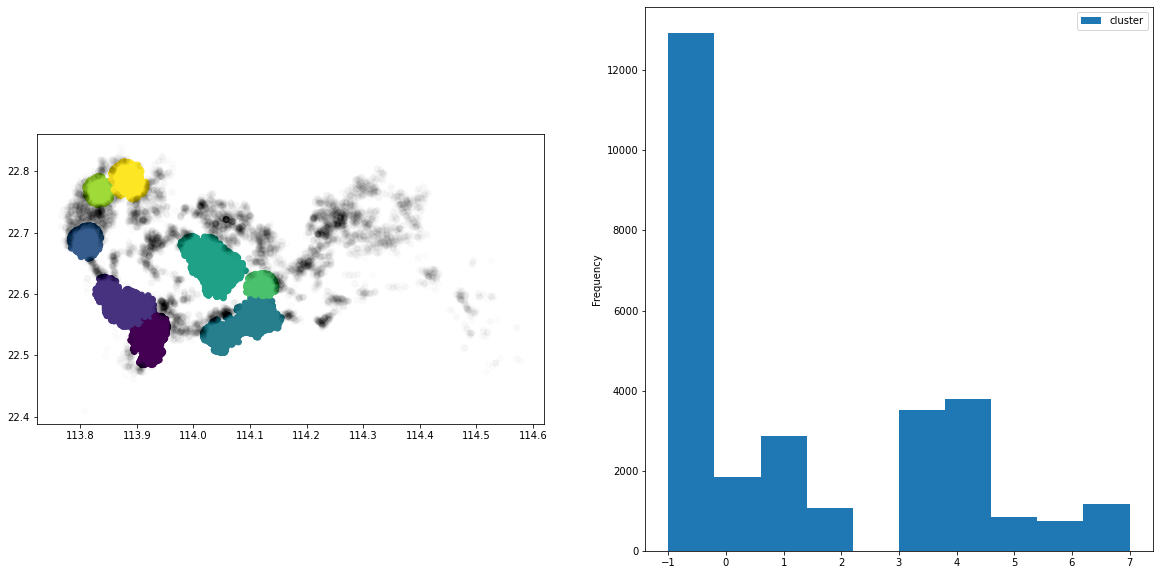

In [44]:
#inputs:
epsilon = 2 #km
min_samples = int(len(df)*0.02) # 1% of the sample should go into the 2km circle

df['cluster'], cluster = dbscan_cluster(df,epsilon,min_samples,plot=True)

In [45]:
from geopy.distance import great_circle

In [46]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

cluster = cluster[cluster.str.len() !=0]
centermost_points = cluster.map(get_centermost_point)


In [47]:
centermost_points

0     (22.52450344377048, 113.92621039489984)
1     (22.58282842447847, 113.87566129270913)
2    (22.687617225543107, 113.81060358093588)
3     (22.54901643131884, 114.08843234376126)
4     (22.64484669794187, 114.03527713081958)
5    (22.611962023116785, 114.11921392855248)
6      (22.76886569846021, 113.8349203499384)
7    (22.786039374783584, 113.88735163383552)
dtype: object

In [48]:
CRS_UNI = 4326
def convert_to_points(centermost_points, local_crs):
    df_tmp = pd.DataFrame([[*a] for a in centermost_points],columns=('x','y'))
    geometry = gpd.points_from_xy(df_tmp.y,df_tmp.x)
    gdf_local_cbd = gpd.GeoDataFrame(geometry = geometry, crs = CRS_UNI)
    gdf_local_cbd = gdf_local_cbd.to_crs(local_crs)
    return gdf_local_cbd

In [49]:
local_crs = 4326
gdf_local_cbd = convert_to_points(centermost_points, local_crs)

<AxesSubplot:>

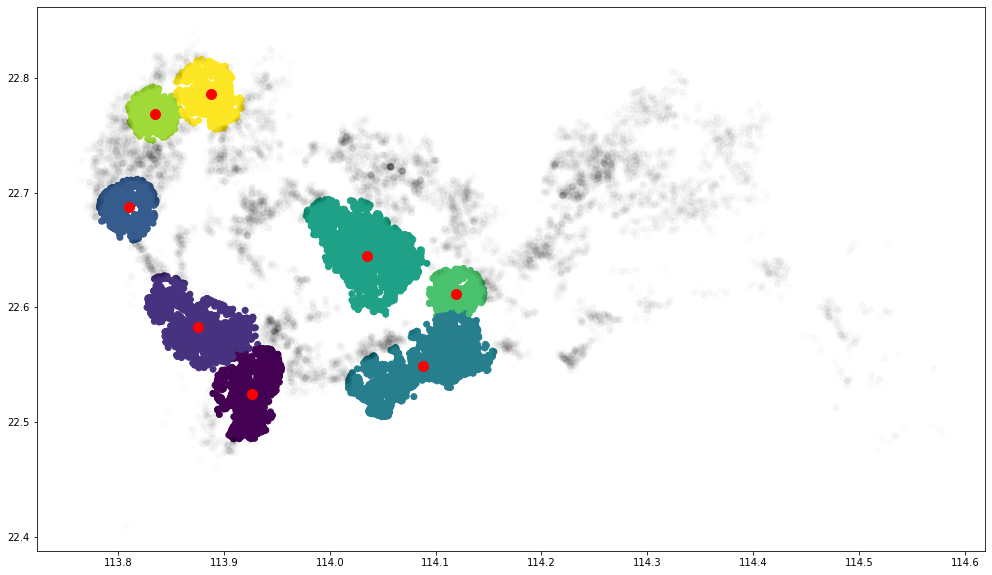

In [50]:
fig,ax1 = plt.subplots(figsize=(20,10))
df.loc[df.cluster!=-1].plot(ax=ax1,column='cluster')
df.loc[df.cluster==-1].plot(ax=ax1,color='black',alpha=0.01)
gdf_local_cbd.plot(ax=ax1, color='red', markersize=100)

In [51]:
# berlin subcenters look ok - let's try it for all

In [52]:
gdf_local_cbd

,geometry
0,POINT (113.92621 22.52450)
1,POINT (113.87566 22.58283)
2,POINT (113.81060 22.68762)
3,POINT (114.08843 22.54902)
4,POINT (114.03528 22.64485)
5,POINT (114.11921 22.61196)
6,POINT (113.83492 22.76887)
7,POINT (113.88735 22.78604)


In [53]:
gdf_local_cbd.to_csv(r"D:\bike\code\metro\Preprocessing-bike data\code\day_buffer\variable\distance\gdf_local_cbd_commercial_building.csv")

## work

In [54]:
df = gpd.read_file(r"D:\bike\data\深圳市POI\ShapeFile\深圳市_公司企业_20220602_041919.shp")

In [55]:
df.head()

,parent,distance,pcode,importance,biz_ext,recommend,type,photos,discount_n,gridcode,...,groupbuy_n,longitude_,latitude_g,longitud_1,latitude_w,typecode_s,大类,中类,小类,geometry
0,[],[],440000,[],"{'cost': [], 'rating': []}",0,公司企业;公司企业;公司企业,[],0,3413061120,...,0,113.765033,22.681966,113.759875,22.684818,170000,公司企业,公司企业,公司企业,POINT (113.75987 22.68482)
1,[],[],440000,[],"{'cost': [], 'rating': []}",0,公司企业;公司;冶金化工,[],0,3413061110,...,0,113.766580,22.680207,113.761424,22.683060,170205,公司企业,公司,冶金化工,POINT (113.76142 22.68306)
2,[],[],440000,[],"{'cost': [], 'rating': []}",0,公司企业;公司企业;公司企业,"[{'title': [], 'url': 'http://store.is.autonav...",0,3413061121,...,0,113.768497,22.681771,113.763343,22.684625,170000,公司企业,公司企业,公司企业,POINT (113.76334 22.68462)
3,[],[],440000,[],"{'cost': [], 'rating': []}",0,公司企业;公司;公司,[],0,3413060101,...,0,113.768935,22.668655,113.763782,22.671512,170200,公司企业,公司,公司,POINT (113.76378 22.67151)
4,[],[],440000,[],"{'cost': [], 'rating': []}",0,公司企业;工厂;工厂,[],0,3313768322,...,0,113.796279,22.656903,113.791178,22.659794,170300,公司企业,工厂,工厂,POINT (113.79118 22.65979)


In [56]:
len(df)

139535

In [57]:
df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

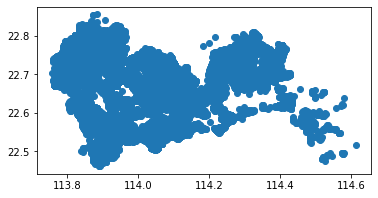

In [58]:
df.plot()

In [59]:
from sklearn.cluster import DBSCAN
import numpy as np
from shapely.geometry import MultiPoint

In [60]:
def dbscan_cluster(gdf_tmp, epsilon, min_samples, plot=False): 

    # convert epsilon from km to radians
    kms_per_radian = 6371.0088

    gdf_tmp = gdf_tmp.to_crs(4326)
    gdf_tmp['lat'] = gdf_tmp.geometry.y
    gdf_tmp['lon'] = gdf_tmp.geometry.x
    coords = gdf_tmp[['lat','lon']].to_numpy()

    # set up the algorithm
    dbscan = DBSCAN(
        eps = epsilon/kms_per_radian,
        min_samples = min_samples,
        algorithm = 'ball_tree',
        metric = 'haversine')

    # fit the algorithm
    db = dbscan.fit(np.radians(coords))

    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
    print('Number of clusters: {}'.format(num_clusters))

    if plot:
        gdf_tmp['cluster'] = cluster_labels
        fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(20,10))
        gdf_tmp.loc[gdf_tmp.cluster!=-1].plot(ax=ax1,column='cluster')
        gdf_tmp.loc[gdf_tmp.cluster==-1].plot(ax=ax1,color='black',alpha=0.01)
        gdf_tmp[['cluster']].plot.hist(ax=ax2)

    return cluster_labels, clusters

Number of clusters: 9


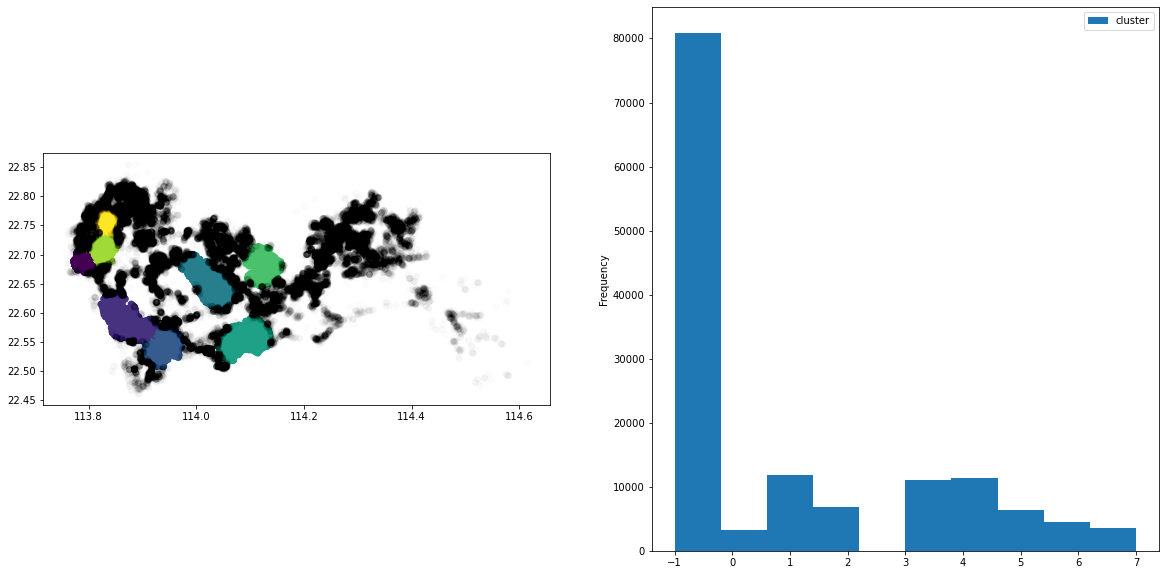

In [61]:
#inputs:
epsilon = 2 #km
min_samples = int(len(df)*0.02) # 2% of the sample should go into the 2km circle

df['cluster'], cluster = dbscan_cluster(df,epsilon,min_samples,plot=True)

In [62]:
from geopy.distance import great_circle

In [63]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

cluster = cluster[cluster.str.len() !=0]
centermost_points = cluster.map(get_centermost_point)


In [64]:
centermost_points

0      (22.68787129437534, 113.7931321996444)
1    (22.589075364143447, 113.87015137064364)
2       (22.53909128681581, 113.937514834389)
3     (22.65507035875417, 114.02180896858336)
4     (22.55053010217473, 114.08968490967496)
5      (22.68018553942304, 114.1226519637432)
6    (22.710932490198605, 113.82883785090436)
7     (22.756500548829838, 113.8327162949555)
dtype: object

In [65]:
CRS_UNI = 4326
def convert_to_points(centermost_points, local_crs):
    df_tmp = pd.DataFrame([[*a] for a in centermost_points],columns=('x','y'))
    geometry = gpd.points_from_xy(df_tmp.y,df_tmp.x)
    gdf_local_cbd = gpd.GeoDataFrame(geometry = geometry, crs = CRS_UNI)
    gdf_local_cbd = gdf_local_cbd.to_crs(local_crs)
    return gdf_local_cbd

In [66]:
local_crs = 4326
gdf_local_cbd = convert_to_points(centermost_points, local_crs)

<AxesSubplot:>

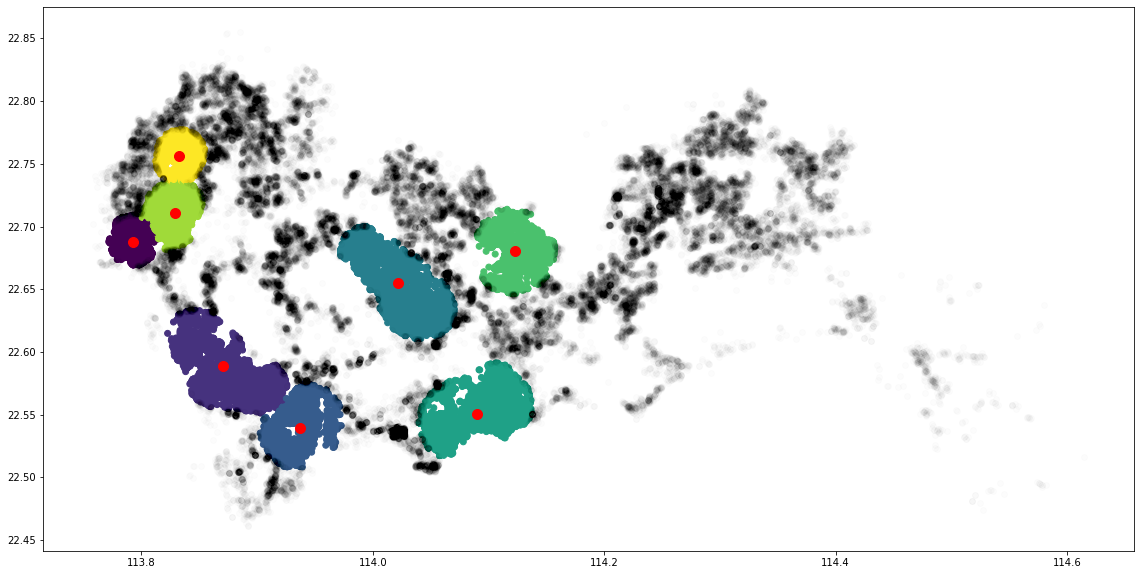

In [67]:
fig,ax1 = plt.subplots(figsize=(20,10))
df.loc[df.cluster!=-1].plot(ax=ax1,column='cluster')
df.loc[df.cluster==-1].plot(ax=ax1,color='black',alpha=0.01)
gdf_local_cbd.plot(ax=ax1, color='red', markersize=100)

In [68]:
# berlin subcenters look ok - let's try it for all

In [69]:
gdf_local_cbd

,geometry
0,POINT (113.79313 22.68787)
1,POINT (113.87015 22.58908)
2,POINT (113.93751 22.53909)
3,POINT (114.02181 22.65507)
4,POINT (114.08968 22.55053)
5,POINT (114.12265 22.68019)
6,POINT (113.82884 22.71093)
7,POINT (113.83272 22.75650)


In [70]:
gdf_local_cbd.to_csv(r"D:\bike\code\metro\Preprocessing-bike data\code\day_buffer\variable\distance\gdf_local_cbd_enterprise.csv")

## education

In [71]:
df = gpd.read_file(r"D:\bike\data\深圳市POI\ShapeFile\深圳市_科教文化服务_20220602_041139.shp")

In [72]:
df.head()

,parent,distance,pcode,importance,biz_ext,recommend,type,photos,discount_n,gridcode,...,groupbuy_n,longitude_,latitude_g,longitud_1,latitude_w,typecode_s,大类,中类,小类,geometry
0,[],[],440000,[],"{'cost': [], 'rating': []}",0,科教文化服务;学校;幼儿园,"[{'title': [], 'url': 'http://store.is.autonav...",0,3413060322,...,0,113.799630,22.674170,113.794535,22.677062,141204,科教文化服务,学校,幼儿园,POINT (113.79454 22.67706)
1,[],[],440000,[],"{'cost': [], 'rating': '0.0'}",0,科教文化服务;学校;幼儿园,"[{'title': [], 'url': 'http://store.is.autonav...",0,3413060322,...,0,113.799602,22.674168,113.794507,22.677060,141204,科教文化服务,学校,幼儿园,POINT (113.79451 22.67706)
2,[],[],440000,[],"{'cost': [], 'rating': []}",0,科教文化服务;科教文化场所;科教文化场所,[],0,3413060202,...,0,113.783503,22.668713,113.778374,22.671584,140000,科教文化服务,科教文化场所,科教文化场所,POINT (113.77837 22.67158)
3,[],[],440000,[],"{'cost': [], 'rating': '4.2'}",0,科教文化服务;驾校;驾校,"[{'title': [], 'url': 'http://store.is.autonav...",0,3413061212,...,0,113.785571,22.679656,113.780445,22.682527,141500,科教文化服务,驾校,驾校,POINT (113.78045 22.68253)
4,[],[],440000,[],"{'cost': [], 'rating': '3.6'}",0,科教文化服务;科教文化场所;科教文化场所|生活服务;生活服务场所;生活服务场所,[],0,3413060312,...,0,113.798920,22.671505,113.793824,22.674397,140000,科教文化服务,科教文化场所,科教文化场所,POINT (113.79382 22.67440)


In [73]:
len(df)

34296

In [74]:
df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

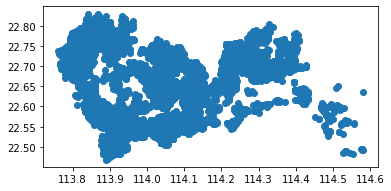

In [75]:
df.plot()

In [76]:
from sklearn.cluster import DBSCAN
import numpy as np
from shapely.geometry import MultiPoint

In [77]:
def dbscan_cluster(gdf_tmp, epsilon, min_samples, plot=False): 

    # convert epsilon from km to radians
    kms_per_radian = 6371.0088

    gdf_tmp = gdf_tmp.to_crs(4326)
    gdf_tmp['lat'] = gdf_tmp.geometry.y
    gdf_tmp['lon'] = gdf_tmp.geometry.x
    coords = gdf_tmp[['lat','lon']].to_numpy()

    # set up the algorithm
    dbscan = DBSCAN(
        eps = epsilon/kms_per_radian,
        min_samples = min_samples,
        algorithm = 'ball_tree',
        metric = 'haversine')

    # fit the algorithm
    db = dbscan.fit(np.radians(coords))

    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
    print('Number of clusters: {}'.format(num_clusters))

    if plot:
        gdf_tmp['cluster'] = cluster_labels
        fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(20,10))
        gdf_tmp.loc[gdf_tmp.cluster!=-1].plot(ax=ax1,column='cluster')
        gdf_tmp.loc[gdf_tmp.cluster==-1].plot(ax=ax1,color='black',alpha=0.01)
        gdf_tmp[['cluster']].plot.hist(ax=ax2)

    return cluster_labels, clusters

Number of clusters: 6


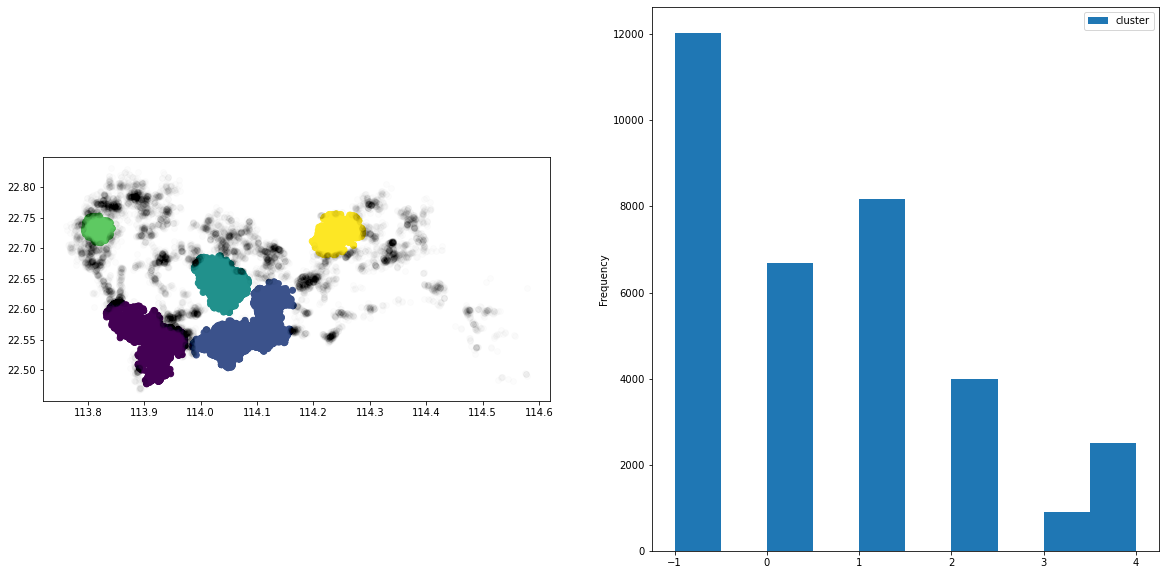

In [78]:
#inputs:
epsilon = 2 #km
min_samples = int(len(df)*0.02) # 2% of the sample should go into the 2km circle

df['cluster'], cluster = dbscan_cluster(df,epsilon,min_samples,plot=True)

In [79]:
from geopy.distance import great_circle

In [80]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

cluster = cluster[cluster.str.len() !=0]
centermost_points = cluster.map(get_centermost_point)


In [81]:
centermost_points

0     (22.547527612898183, 113.905595009526)
1    (22.56258694884805, 114.08600138237168)
2     (22.6402450214154, 114.03550900535625)
3    (22.730946003242213, 113.8182621082908)
4    (22.72223630097223, 114.23841093439408)
dtype: object

In [82]:
CRS_UNI = 4326
def convert_to_points(centermost_points, local_crs):
    df_tmp = pd.DataFrame([[*a] for a in centermost_points],columns=('x','y'))
    geometry = gpd.points_from_xy(df_tmp.y,df_tmp.x)
    gdf_local_cbd = gpd.GeoDataFrame(geometry = geometry, crs = CRS_UNI)
    gdf_local_cbd = gdf_local_cbd.to_crs(local_crs)
    return gdf_local_cbd

In [83]:
local_crs = 4326
gdf_local_cbd = convert_to_points(centermost_points, local_crs)

<AxesSubplot:>

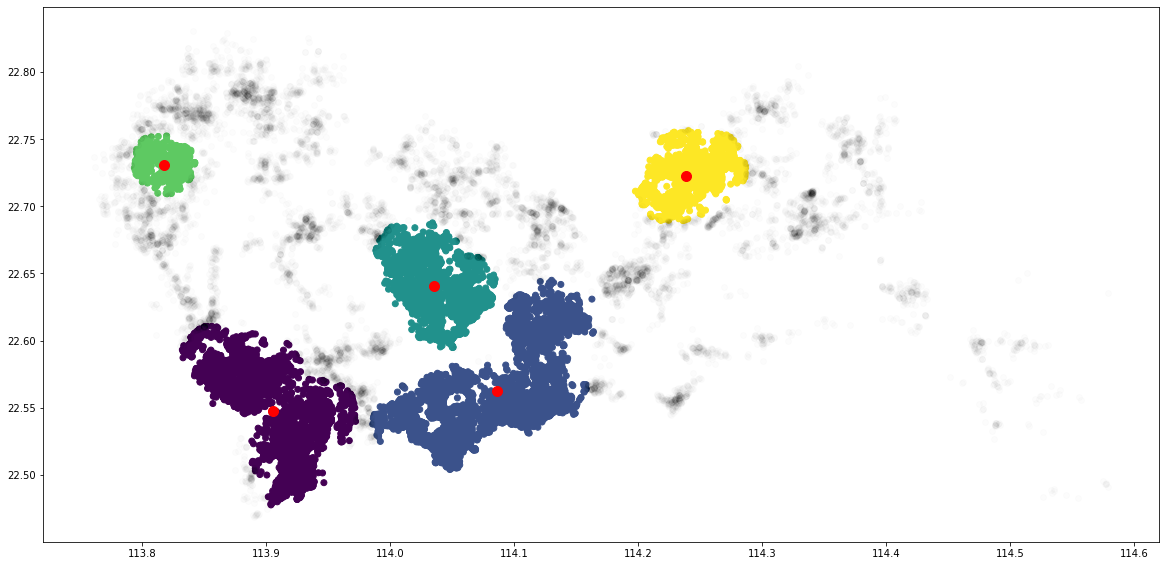

In [84]:
fig,ax1 = plt.subplots(figsize=(20,10))
df.loc[df.cluster!=-1].plot(ax=ax1,column='cluster')
df.loc[df.cluster==-1].plot(ax=ax1,color='black',alpha=0.01)
gdf_local_cbd.plot(ax=ax1, color='red', markersize=100)

In [85]:
# berlin subcenters look ok - let's try it for all

In [86]:
gdf_local_cbd

,geometry
0,POINT (113.90560 22.54753)
1,POINT (114.08600 22.56259)
2,POINT (114.03551 22.64025)
3,POINT (113.81826 22.73095)
4,POINT (114.23841 22.72224)


In [87]:
gdf_local_cbd.to_csv(r"D:\bike\code\metro\Preprocessing-bike data\code\day_buffer\variable\distance\gdf_local_cbd_education.csv")